In [1]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 

import functional_sensitivity_lib as fun_sens_lib
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)

import json 


# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

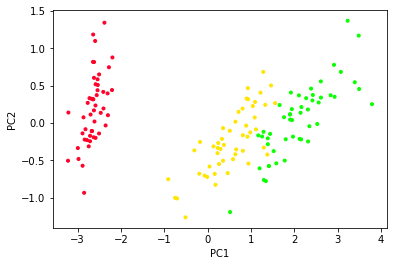

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

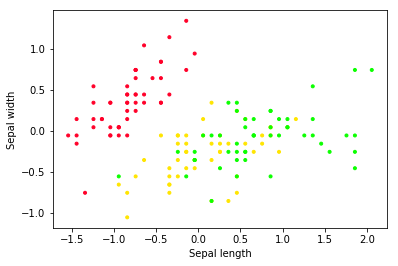

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [10]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [11]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [12]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [13]:
set_truth = False

In [14]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [15]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

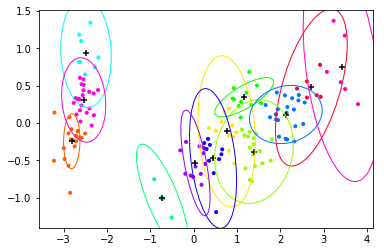

In [16]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [17]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


# Optimize!

In [18]:
load_from_disc = True

In [19]:
if not load_from_disc: 
    t0 = time.time()
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500)
    t_newton = time.time() - t0

    print('done. ')
    
else: 

    full_data_fit_file = '../iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
    with open(full_data_fit_file, 'r') as fp:
        fit_dict = json.load(fp)

    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)

    best_param = model.global_vb_params.get_free()

In [20]:
newton_results = deepcopy(model)

In [21]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [22]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [23]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

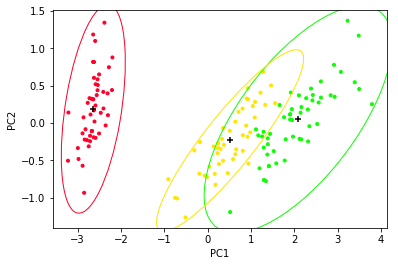

In [24]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [25]:
# plt.scatter(pc_features[bnp_clusters == 0, 0], pc_features[bnp_clusters == 0, 1])

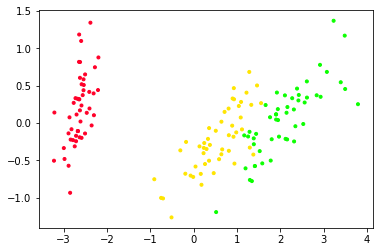

In [26]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

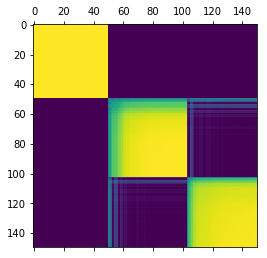

In [27]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [28]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

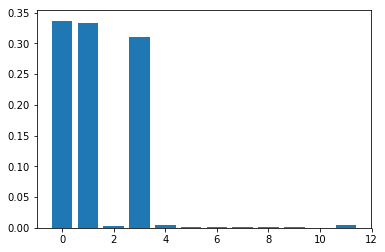

In [29]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

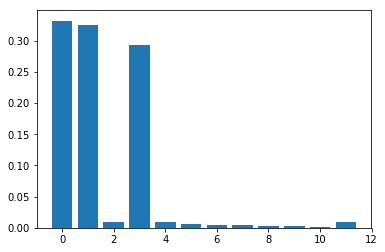

In [30]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  2.,   0.,   1.,   1.,   1.,   5.,   2.,   2.,   6., 130.]),
 array([0.44352936, 0.49917643, 0.55482349, 0.61047055, 0.66611762,
        0.72176468, 0.77741174, 0.83305881, 0.88870587, 0.94435294,
        1.        ]),
 <a list of 10 Patch objects>)

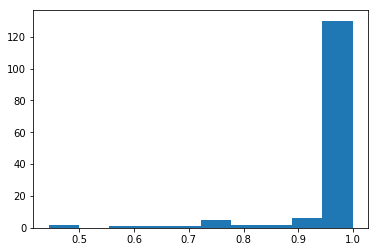

In [31]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Functional sensitivity

In [32]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(deepcopy(model), moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [33]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [34]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))

0.07230487288465379 2452.4187642002653


In [35]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [36]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

In [37]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

# Worst case influence

In [38]:
worst_case_neg = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = -1).flatten()

worst_case_pos = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = 1).flatten()

In [39]:
theta = np.linspace(0.01, 0.99, 100)

In [40]:
epsilon = 0.01

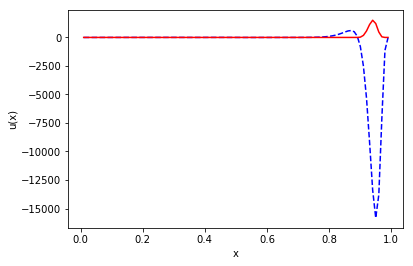

In [41]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_neg(theta).flatten() * epsilon, 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

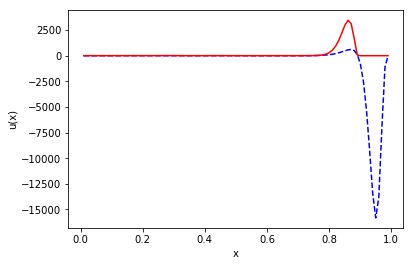

In [43]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_pos(theta).flatten(), 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

In [44]:
# Get interpolating points
n_int_points = 100
int_points_x_ = np.linspace(0.0, 1.0, n_int_points)
int_points_x = np.sort((1 - (np.power(10, int_points_x_) - 1) / 9) * (1 - 0.6e-6) + 0.5e-6)

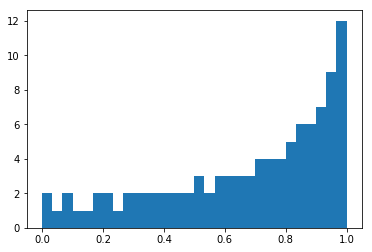

In [45]:
# plt.plot(int_points_x, np.zeros(len(int_points_x)), '.', alpha = 0.005)
plt.hist(int_points_x, bins = 30); 

In [46]:
np.max(int_points_x)

0.9999998999999999

In [47]:
np.min(int_points_x)

5e-07

In [48]:
import interpolation_lib as interp_lib

# knot_vector = np.array([0.0, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 1.0])
knot_vector = int_points_x.flatten()
worst_case_pos_interp = interp_lib.BsplineRegression(fun = worst_case_pos, 
                                                     x_reg= int_points_x.flatten(), 
                                                    knot_vector = knot_vector, 
                                                    order = 3)

worst_case_neg_interp = interp_lib.BsplineRegression(fun = worst_case_neg, 
                                                     x_reg= int_points_x.flatten(), 
                                                    knot_vector = knot_vector, 
                                                    order = 3)

condition number:  8.924553350311173
condition number:  8.924553350311173


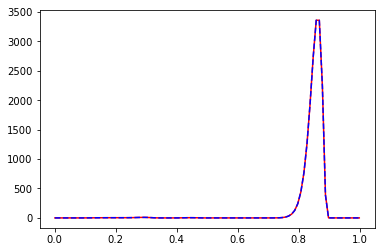

In [62]:
theta = np.linspace(0.001, 0.999, 100)
plt.plot(theta, worst_case_pos_interp.eval_interp_fun(theta), color = 'red')
plt.plot(theta, worst_case_pos_interp.eval_fun(theta), '--', color = 'blue')

In [63]:
np.max(np.abs(worst_case_pos_interp.eval_interp_fun(theta) - worst_case_pos_interp.eval_fun(theta)))

3.1894265428817903

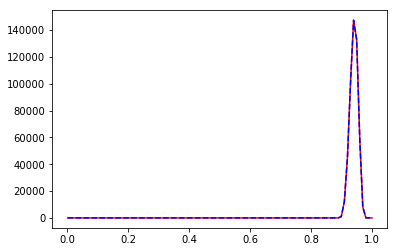

In [64]:
plt.plot(theta, worst_case_neg_interp.eval_interp_fun(theta), color = 'red')
plt.plot(theta, worst_case_neg_interp.eval_fun(theta), '--', color = 'blue')

In [91]:
import scipy as osp

In [115]:
def get_worst_case_norm(linear_sens, g_eta, sign ): 
    integrand = lambda theta : np.max(sign * np.einsum('i, i...->...', g_eta, \
                        linear_sens.total_influence_function(theta)), 0)**2 \
                / sp.stats.beta.pdf(theta, 1, linear_sens.model.prior_params['alpha'].get())
    
    return integrand

In [116]:
foo = get_worst_case_norm(linear_sens, g_eta_nclust, 1)

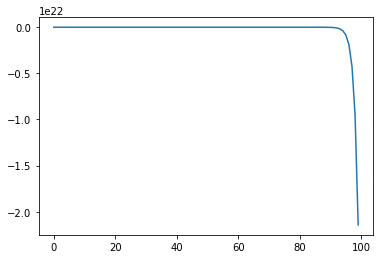

In [120]:
x = np.linspace(-10, 10, 100)
expit_x = sp.special.expit(x)

plt.plot(foo(expit_x) / (np.log(expit_x) * (1 - np.log(expit_x))))

In [65]:
worst_case_fun_sens_mat_pos = np.zeros((len(best_param), k_approx - 1))
worst_case_fun_sens_mat_neg = np.zeros((len(best_param), k_approx - 1))
for k in range(k_approx - 1): 
    worst_case_fun_sens_mat_pos[:, k] = \
        linear_sens.get_functional_sensitivity(lambda x : np.max(worst_case_pos_interp.eval_interp_fun(x), 0), k)
    worst_case_fun_sens_mat_neg[:, k] = \
        linear_sens.get_functional_sensitivity(lambda x : np.max(worst_case_neg_interp.eval_interp_fun(x), 0), k)

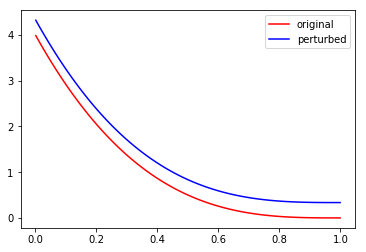

In [130]:
# The perturbed prior

plt.plot(theta, sp.stats.beta.pdf(theta, 1, linear_sens.model.prior_params['alpha'].get()), color = 'red')
plt.plot(theta, np.exp(np.log(np.max(worst_case_pos_interp.eval_interp_fun(theta), 0) * epsilon + \
                   sp.stats.beta.pdf(theta, 1, linear_sens.model.prior_params['alpha'].get()))), color = 'blue')

plt.legend(('original', 'perturbed'))

In [66]:
# Perturb and re-optimize with positive perturbation
epsilon = 0.000001

model_worst_case_pos_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : np.max(worst_case_pos_interp.eval_interp_fun(x), 0) * epsilon)

pos_pert_worst_case_opt_free_param = \
    model_worst_case_pos_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.65935982103895
Iter: 10	 RMSE: 9.098901452244418	 Objective: -339.1714050960244
Iter: 20	 RMSE: 9.09472896233159	 Objective: -339.30984156980423
Iter: 30	 RMSE: 9.097362258630547	 Objective: -339.52727214741543
Iter: 40	 RMSE: 9.09616883429285	 Objective: -339.4540027046205
Iter: 50	 RMSE: 9.11915727599227	 Objective: -339.8583570177764
Iter: 60	 RMSE: 9.114799913344404	 Objective: -339.8819666660863
Iter: 70	 RMSE: 9.11452429651555	 Objective: -339.882908919188
Iter: 80	 RMSE: 9.1145366083726	 Objective: -339.88291926453513
Iter: 90	 RMSE: 9.114539607642232	 Objective: -339.8829193924816
Optimization terminated successfully.
         Current function value: -339.882919
         Iterations: 78
         Function evaluations: 93
         Gradient evaluations: 93
         Current function value: -339.882919
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_dif

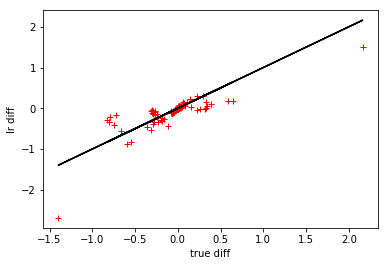

In [67]:
lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_pos, epsilon * np.ones(k_approx - 1))

diff_vec = pos_pert_worst_case_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [68]:
get_e_number_clusters_from_free_par(model, best_param)

6.294744650608919

In [69]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pos_pert_worst_case_opt_free_param))

perturbed e_number_clusters: 4.257620752879828


In [70]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 4.9438624421360595


In [71]:
epsilons = np.arange(1, 11) * 1e-6

In [73]:
pert_opt_free_param_list = []

u = lambda x : np.max(worst_case_pos_interp.eval_interp_fun(x), 0)

# re-optimize for each epsilon
for i in tqdm(range(len(epsilons))): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    model_u_pert = gmm_utils.DPGaussianMixture(
        model.y, model.k_approx, model.prior_params, gh_deg = 8, \
        use_bnp_prior = model.vb_params.use_bnp_prior, \
        use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
        u = lambda x : u(x) * epsilons[i])
    
    pert_opt_free_param_list.append(
        model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = True)[0])


  0%|          | 0/10 [00:00<?, ?it/s]

optimizing when epsilon = 1e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.65935982103895
Iter: 10	 RMSE: 9.098901452244418	 Objective: -339.1714050960244
Iter: 20	 RMSE: 9.09472896233159	 Objective: -339.30984156980423
Iter: 30	 RMSE: 9.097362258630547	 Objective: -339.52727214741543
Iter: 40	 RMSE: 9.09616883429285	 Objective: -339.4540027046205
Iter: 50	 RMSE: 9.11915727599227	 Objective: -339.8583570177764
Iter: 60	 RMSE: 9.114799913344404	 Objective: -339.8819666660863
Iter: 70	 RMSE: 9.11452429651555	 Objective: -339.882908919188
Iter: 80	 RMSE: 9.1145366083726	 Objective: -339.88291926453513
Iter: 90	 RMSE: 9.114539607642232	 Objective: -339.8829193924816
Optimization terminated successfully.
         Current function value: -339.882919
         Iterations: 78
         Function evaluations: 93
         Gradient evaluations: 93


 10%|█         | 1/10 [00:38<05:43, 38.14s/it]

         Current function value: -339.882919
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0005307586856183876, f_diff = 6.032792043697555e-10
optimizing when epsilon = 2e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.9861310259699
Iter: 10	 RMSE: 9.099142746910466	 Objective: -339.79401172668304
Iter: 20	 RMSE: 9.093701277018159	 Objective: -339.91886864845173
Iter: 30	 RMSE: 9.090372807670558	 Objective: -340.17445914516287
Iter: 40	 RMSE: 9.100370215365407	 Objective: -340.3931499270413
Iter: 50	 RMSE: 9.120383352203865	 Objective: -340.56763026402
Iter: 60	 RMSE: 9.114650854171236	 Objective: -340.5903619581704
Iter: 70	 RMSE: 9.114493248797437	 Objective: -340.5913885823512
Iter: 80	 RMSE: 9.114527985168547	 Objective: -340.5914075336153
Iter: 90	 RMSE: 9.11454936361592	 Objective: -340.59140827620325
Optimization terminated successfully.
         Current function value: -340.59140

 20%|██        | 2/10 [01:12<04:50, 36.32s/it]

         Current function value: -340.591408
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0005046972923651309, f_diff = 4.5855585995013826e-10
optimizing when epsilon = 3e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.2218601333147
Iter: 10	 RMSE: 9.09880068468059	 Objective: -340.1716622857044
Iter: 20	 RMSE: 9.093170277076192	 Objective: -340.29679631612436
Iter: 30	 RMSE: 9.092849131286274	 Objective: -340.5786206591081
Iter: 40	 RMSE: 9.099614891782064	 Objective: -340.811867945422
Iter: 50	 RMSE: 9.118719534646663	 Objective: -341.001860459461
Iter: 60	 RMSE: 9.114442456513455	 Objective: -341.0206291087518
Iter: 70	 RMSE: 9.114561156372162	 Objective: -341.02142253984556
Iter: 80	 RMSE: 9.114541320954205	 Objective: -341.0214357685387
Iter: 90	 RMSE: 9.114549624885356	 Objective: -341.0214359904383
Optimization terminated successfully.
         Current function value: -341.021436

 30%|███       | 3/10 [01:48<04:13, 36.19s/it]

         Current function value: -341.021436
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00020692870589759477, f_diff = 9.487166607868858e-11
optimizing when epsilon = 4e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.4085257873933
Iter: 10	 RMSE: 9.098978953676907	 Objective: -340.44308079328954
Iter: 20	 RMSE: 9.093122942664838	 Objective: -340.5704132156031
Iter: 30	 RMSE: 9.097434046212124	 Objective: -340.86227557514655
Iter: 40	 RMSE: 9.097642227805563	 Objective: -341.07477416279477
Iter: 50	 RMSE: 9.1165585640313	 Objective: -341.3078885668151
Iter: 60	 RMSE: 9.115250811132638	 Objective: -341.33423586013913
Iter: 70	 RMSE: 9.114552658627384	 Objective: -341.3349888522707
Iter: 80	 RMSE: 9.114549904578055	 Objective: -341.3350023344893
Iter: 90	 RMSE: 9.114550309340128	 Objective: -341.3350029174935
Optimization terminated successfully.
         Current function value: -341.335

 40%|████      | 4/10 [02:26<03:39, 36.65s/it]

Iter: 100	 RMSE: 9.114547366497783	 Objective: -341.335002921765
         Current function value: -341.335003
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0003330249261389033, f_diff = 2.4937207854236476e-10
optimizing when epsilon = 4.9999999999999996e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.56387987664345
Iter: 10	 RMSE: 9.10023551718747	 Objective: -340.6941951477311
Iter: 20	 RMSE: 9.091840219293907	 Objective: -340.83891344332704
Iter: 30	 RMSE: 9.099152983694932	 Objective: -341.11209920347824
Iter: 40	 RMSE: 9.101789450959595	 Objective: -341.3653428173454
Iter: 50	 RMSE: 9.114428746263703	 Objective: -341.5696399360569
Iter: 60	 RMSE: 9.115028869363364	 Objective: -341.5833025968846
Iter: 70	 RMSE: 9.114533935399418	 Objective: -341.58391172619247
Iter: 80	 RMSE: 9.114516817447624	 Objective: -341.58392503382197
Iter: 90	 RMSE: 9.114553974306537	 Objective: -341.583925454

 50%|█████     | 5/10 [03:04<03:04, 36.85s/it]

         Current function value: -341.583925
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00022072946562427586, f_diff = 1.0697931429604068e-10
optimizing when epsilon = 6e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.69731756745915
Iter: 10	 RMSE: 9.099234481535074	 Objective: -340.86583957301167
Iter: 20	 RMSE: 9.09121835288046	 Objective: -341.016877583656
Iter: 30	 RMSE: 9.10336655599915	 Objective: -341.2986932959919
Iter: 40	 RMSE: 9.102256567846013	 Objective: -341.57066877463916
Iter: 50	 RMSE: 9.116354288593305	 Objective: -341.7684130075859
Iter: 60	 RMSE: 9.113982990200844	 Objective: -341.7905288251069
Iter: 70	 RMSE: 9.114462721607747	 Objective: -341.79153551043606
Iter: 80	 RMSE: 9.114521579008075	 Objective: -341.7915715784039
Iter: 90	 RMSE: 9.11455761696718	 Objective: -341.79157231708274
Iter: 100	 RMSE: 9.114545394713582	 Objective: -341.79157235007085
Optimization

 60%|██████    | 6/10 [03:41<02:27, 36.87s/it]

         Current function value: -341.791572
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0003440661000599809, f_diff = 2.523847797419876e-10
optimizing when epsilon = 7e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.814476590718
Iter: 10	 RMSE: 9.098872874061591	 Objective: -341.01512177934814
Iter: 20	 RMSE: 9.09109100540044	 Objective: -341.17249471298294
Iter: 30	 RMSE: 9.104041057805796	 Objective: -341.4659667241644
Iter: 40	 RMSE: 9.10145704321396	 Objective: -341.7622466158081
Iter: 50	 RMSE: 9.113538738547941	 Objective: -341.93653267554936
Iter: 60	 RMSE: 9.11486665904838	 Objective: -341.96942532820134
Iter: 70	 RMSE: 9.114665147982	 Objective: -341.97049154445017
Iter: 80	 RMSE: 9.114500006344597	 Objective: -341.9705209644367
Iter: 90	 RMSE: 9.114557868660995	 Objective: -341.97052206233894
Iter: 100	 RMSE: 9.114543880207048	 Objective: -341.97052211256056
Optimization ter

 70%|███████   | 7/10 [04:17<01:50, 36.76s/it]

Optimization terminated successfully.
         Current function value: -341.970522
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00020687033926868943, f_diff = 9.112000043387525e-11
optimizing when epsilon = 8e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -339.9190291126223
Iter: 10	 RMSE: 9.098773458236453	 Objective: -341.1474764273059
Iter: 20	 RMSE: 9.089094442736242	 Objective: -341.31226488319714
Iter: 30	 RMSE: 9.099225509385152	 Objective: -341.62829652558395
Iter: 40	 RMSE: 9.106885191570449	 Objective: -341.92270466874845
Iter: 50	 RMSE: 9.11498654193759	 Objective: -342.1049682619681
Iter: 60	 RMSE: 9.11415380613847	 Objective: -342.127261942183
Iter: 70	 RMSE: 9.11463914388202	 Objective: -342.12830992518985
Iter: 80	 RMSE: 9.114529766918281	 Objective: -342.12833570805753
Iter: 90	 RMSE: 9.114551380009917	 Objective: -342.1283361692588
Iter: 100	 RMSE: 9.114544071761447	 Object

 80%|████████  | 8/10 [04:54<01:13, 36.80s/it]

         Current function value: -342.128336
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.0003630291438078015, f_diff = 2.857518666132819e-10
optimizing when epsilon = 9e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -340.013510616386
Iter: 10	 RMSE: 9.09872331481646	 Objective: -341.2654594163704
Iter: 20	 RMSE: 9.087483259769773	 Objective: -341.44124179191914
Iter: 30	 RMSE: 9.092751075391481	 Objective: -341.76333910466354
Iter: 40	 RMSE: 9.107077864147916	 Objective: -342.04116452928247
Iter: 50	 RMSE: 9.114849657751384	 Objective: -342.2155724291338
Iter: 60	 RMSE: 9.114606655464643	 Objective: -342.26863276196707
Iter: 70	 RMSE: 9.114483609772531	 Objective: -342.26989770598914
Iter: 80	 RMSE: 9.114520919117096	 Objective: -342.2699194793459
Iter: 90	 RMSE: 9.114551361491555	 Objective: -342.26991995025725
Iter: 100	 RMSE: 9.114543996714424	 Objective: -342.26991996565073
Optimizatio

 90%|█████████ | 9/10 [05:30<00:36, 36.70s/it]

         Current function value: -342.269920
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00022480234396732914, f_diff = 1.2323653209023178e-10
optimizing when epsilon = 9.999999999999999e-06
Iter: 0	 RMSE: 9.028010849889903	 Objective: -340.099750126957
Iter: 10	 RMSE: 9.09873333731426	 Objective: -341.3725383218425
Iter: 20	 RMSE: 9.09149450426963	 Objective: -341.712755515417
Iter: 30	 RMSE: 9.109242204993231	 Objective: -341.96645551143195
Iter: 40	 RMSE: 9.103894471198641	 Objective: -342.20549799602435
Iter: 50	 RMSE: 9.112534517770015	 Objective: -342.376039028898
Iter: 60	 RMSE: 9.115276578656777	 Objective: -342.39780076582787
Iter: 70	 RMSE: 9.114624870746491	 Objective: -342.39862121030063
Iter: 80	 RMSE: 9.114528657530087	 Objective: -342.3986387113679
Iter: 90	 RMSE: 9.114545942443032	 Objective: -342.3986390624131
Optimization terminated successfully.
         Current function v

100%|██████████| 10/10 [06:06<00:00, 36.70s/it]

         Current function value: -342.398639
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.000279742237726642, f_diff = 2.0315837900852785e-10


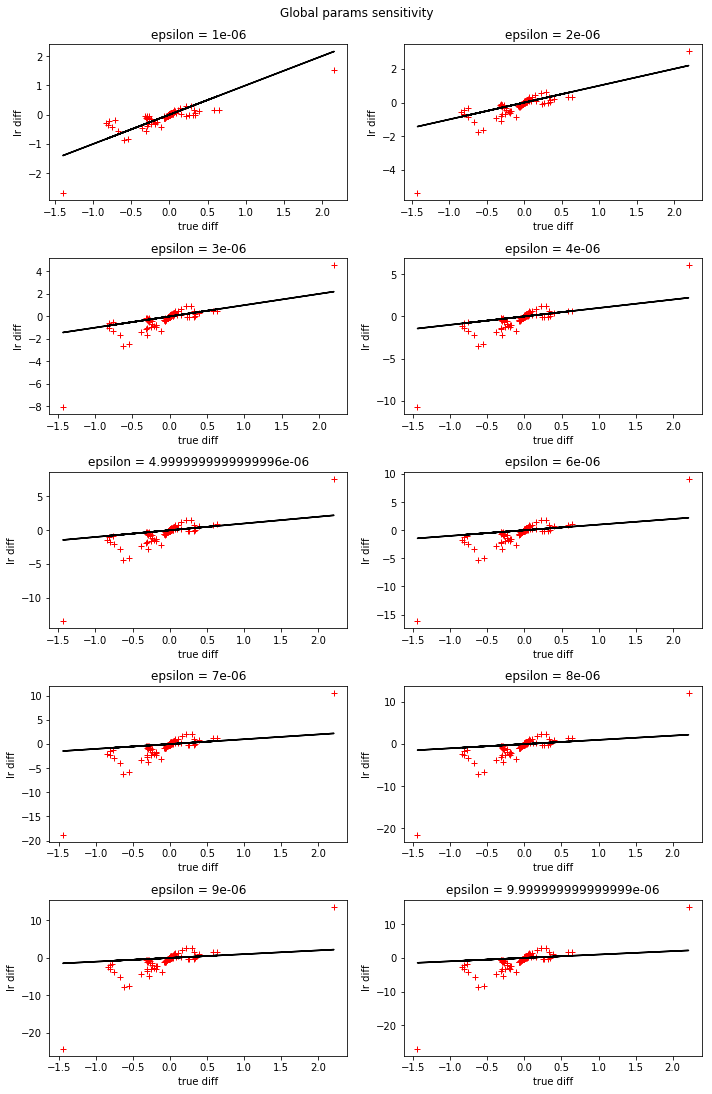

In [75]:
# check global params

# linear_sens.moment_model.set_moments_from_free_par(best_param)

fun_sens_mat = worst_case_fun_sens_mat_pos

f, axarr = plt.subplots(int(len(epsilons) / 2), 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
        
    # get linear response global free params
    lr_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])

    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


(1e-06, 9.999999999999999e-06)

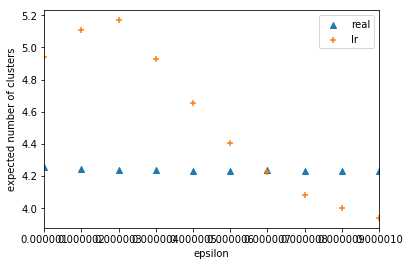

In [121]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1) * epsilons[i])
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')
plt.legend(('real', 'lr'))
plt.xlim((min(epsilons), max(epsilons)))

In [109]:
# Perturb and re-optimize with positive perturbation
epsilon = 0.0001

model_worst_case_neg_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : worst_case_neg_interp.eval_interp_fun(x) * epsilon)

neg_pert_worst_case_opt_free_param = \
    model_worst_case_neg_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -341.4757938785877
Iter: 10	 RMSE: 9.097600736512037	 Objective: -345.5257184608306
Iter: 20	 RMSE: 9.075754324495538	 Objective: -345.9273728478888
Iter: 30	 RMSE: 9.076375368828158	 Objective: -346.2844632733689
Iter: 40	 RMSE: 9.087956289603168	 Objective: -346.43988781178706
Iter: 50	 RMSE: 9.097051617408821	 Objective: -346.47222609113925
Iter: 60	 RMSE: 9.091763217697052	 Objective: -346.50519736210106
Iter: 70	 RMSE: 9.093427779694737	 Objective: -346.5371911832158
Iter: 80	 RMSE: 9.094028074822862	 Objective: -346.5389026826739
Iter: 90	 RMSE: 9.093990176152465	 Objective: -346.53891485605567
Iter: 100	 RMSE: 9.093989095453948	 Objective: -346.5389153220529
Optimization terminated successfully.
         Current function value: -346.538915
         Iterations: 92
         Function evaluations: 110
         Gradient evaluations: 110
Iter: 110	 RMSE: 9.093988131429962	 Objective: -346.53891533496426
         Current function value: -346

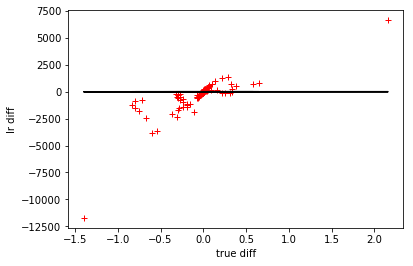

In [111]:
lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_neg, epsilon * np.ones(k_approx - 1))

diff_vec = pos_pert_worst_case_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [112]:
get_e_number_clusters_from_free_par(model, best_param)

6.297529317309175

In [113]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, neg_pert_worst_case_opt_free_param))

perturbed e_number_clusters: 5.204988627088091


In [114]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 1.0
